## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [ ]:
inv1 = ari.resistivity_inversion(case1, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=2.8133, Rhsh=0.7746, 
                                    method='CG', bounds=None)
ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=4.0431, Rhsh=0.6742, 
                                    method='CG', bounds=None)
ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=2.8133, Rhsh=0.7746, 
                                    method='L-BFGS-B', bounds=[(0,1),(None,None)])
ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=4.0431, Rhsh=0.6742, 
                                    method='L-BFGS-B', bounds=[(0,1),(None,None)])
ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)
case2_qinv = ari.quadratic_inversion(case2)

***
# Physics-Informed Neural Network
***

In [1]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [2]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.bn1 = nn.LayerNorm(16)
        self.fc2 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = nn.GELU()(self.fc1(x))
        x = self.bn1(x)
        x = self.fc2(x)
        return x

In [3]:
class PhysicsLoss(nn.Module):
    def __init__(self, Rvsh=2.8133, Rhsh=0.7746, lambda_reg=0):
        super(PhysicsLoss, self).__init__()
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh
        self.lambda_reg = lambda_reg
    
    def physics_loss(self, inputs, targets):
        Rv,  Rh = inputs
        Csh, Rs = targets
        Csh = torch.sigmoid(Csh)

        eq1 = (Csh*self.Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/self.Rhsh + (1-Csh)/Rs) - (1/Rh)
        eq1 = eq1.unsqueeze(0) if eq1.dim()==0 else eq1
        eq2 = eq2.unsqueeze(0) if eq2.dim()==0 else eq2
        eqs = torch.cat((eq1, eq2), dim=0)
        
        return torch.norm(eqs, p=2) + self.lambda_reg*torch.norm(targets,p=2)

    def forward(self, inputs, targets):
        return self.physics_loss(inputs, targets)

In [4]:
def normalize(x, mean, std):
    return (x-mean)/std

def back_normalize(x, mean, std):
    return x*std + mean

In [5]:
res_aniso = case1[['Rv','Rh']]

model     = PINNari()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = PhysicsLoss(Rvsh=2.8133, Rhsh=0.7746)

res_mean, res_std = res_aniso.mean(0).values, res_aniso.std(0).values
data_norm = normalize(res_aniso, res_mean, res_std)

epochs = 10
for epoch in range(epochs):
    for _, row in data_norm.iterrows():
        Rv_true, Rh_true = row['Rv'], row['Rh']
        x = torch.tensor([Rv_true, Rh_true], dtype=torch.float32)
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(x,y)
        loss.backward()
        optimizer.step()

adjoints = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        adjoints[name] = param.grad.clone().detach()

In [6]:
Rvsh, Rhsh = 2.8133, 0.7746
x = torch.tensor(data_norm.values, dtype=torch.float32)
y = model(x).detach().numpy()
y = back_normalize(y, res_mean, res_std)

csh_pred, rs_pred = y[:,0], y[:,1]

Rv_sim = csh_pred*Rvsh + (1-csh_pred)*rs_pred
Rh_sim = csh_pred/Rhsh + (1-csh_pred)/rs_pred

Rv_err = np.abs((Rv_sim - case1['Rv'].values)/case1['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - case1['Rh'].values)/case1['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rs_pred':rs_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=case1.index)

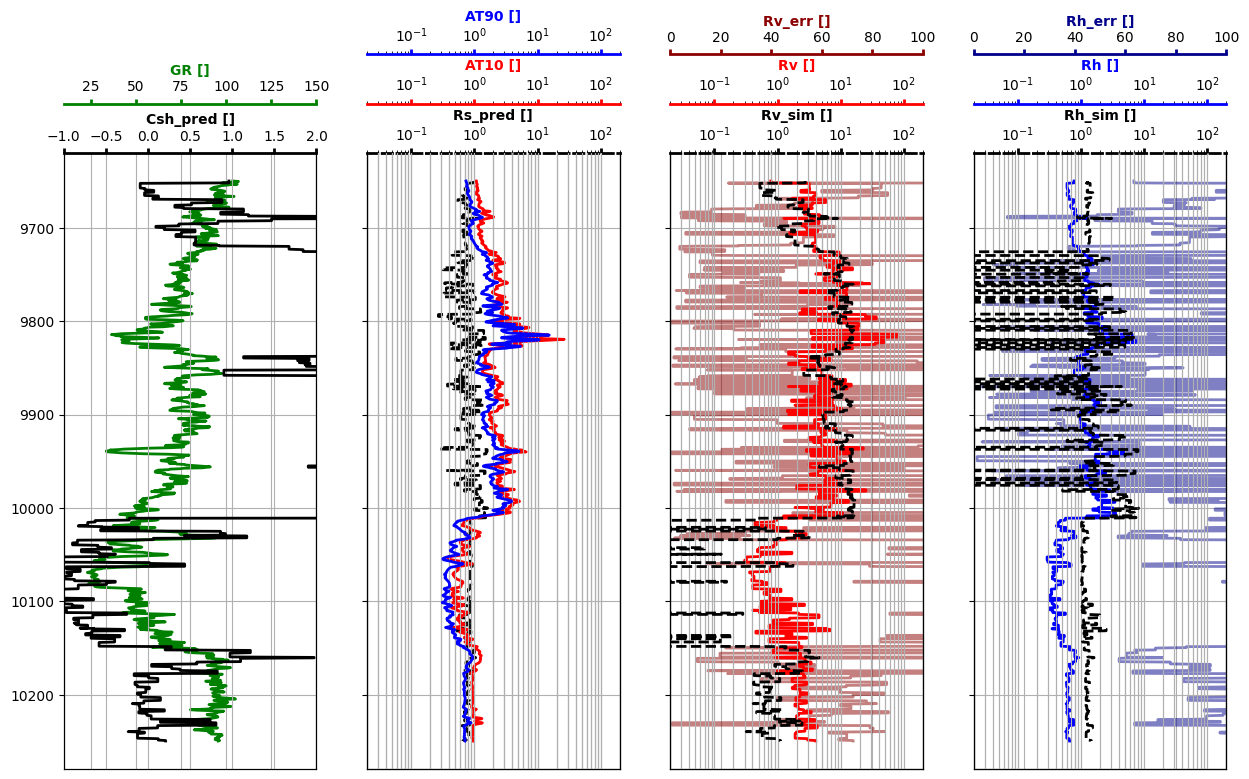

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15,8), sharey=True)
ax1, ax2, ax3, ax4 = axs

ax11 = ax1.twiny()
ari.plot_curve(ax1, case1, 'GR', 10, 150, 'g', pad=8)
ari.plot_curve(ax11, sol, 'Csh_pred', -1, 2, 'k')

ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax21, case1, 'AT10', 0.02, 200, 'r', semilog=True, pad=8)
ari.plot_curve(ax22, case1, 'AT90', 0.02, 200, 'b', semilog=True, pad=16)
ari.plot_curve(ax2, sol, 'Rs_pred', 0.02, 200, 'k', ls='--', semilog=True)

ax31, ax32 = ax3.twiny(), ax3.twiny()
ari.plot_curve(ax31, case1, 'Rv', 0.02, 200, 'r', semilog=True, pad=8)
ari.plot_curve(ax32, sol, 'Rv_sim', 0.02, 200, 'k', ls='--', semilog=True)
ari.plot_curve(ax3, sol, 'Rv_err', 0, 100, 'darkred', alpha=0.5, pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
ari.plot_curve(ax41, case1, 'Rh', 0.02, 200, 'b', semilog=True, pad=8)
ari.plot_curve(ax42, sol, 'Rh_sim', 0.02, 200, 'k', ls='--', semilog=True)
ari.plot_curve(ax4, sol, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, pad=16)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.show()

***
# END